In [68]:
# Summer 2021 Internship project with Oak Ride National Laboratory (ORNL)
# Code Written By: Arjun Viswanathan
# Mentored By: Dr. Junqi Yin
# Date Started: 6/7/2021
# Date TBC: 8/13/2021
# All datasets provided by Dr. Yin

import h5py
import numpy as np
from matplotlib import pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from mpl_toolkits import mplot3d
from tensorflow.keras.layers import Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input, Model

In [50]:
print(str(time.ctime()) + ": Initializing...")
sarsmerscov_train = h5py.File('/ccs/proj/gen150/arjun2612/ORNL/datasets/sars-mers-cov2_train.h5', 'r')
sarsmerscov_val = h5py.File('/ccs/proj/gen150/arjun2612/ORNL/datasets/sars-mers-cov2_val.h5', 'r')
lt = list(open('/ccs/proj/gen150/arjun2612/ORNL/txtFiles/label_train.txt', 'r'))
lv = list(open('/ccs/proj/gen150/arjun2612/ORNL/txtFiles/label_val.txt', 'r')) # open all files

label_training = np.array([])
label_validation = np.array([])

for i in range(len(lt)):
    num = int(str(lt[i]).strip('\n'))
    label_training = np.append(label_training, num)
    
for j in range(len(lv)):
    num = int(str(lv[j]).strip('\n'))
    label_validation = np.append(label_validation, num)

trainset = np.array(sarsmerscov_train['contact_maps']).astype(float) # 616207 x 24 x 24 x 1
valset = np.array(sarsmerscov_val['contact_maps']).astype(float) # 152052 x 24 x 24 x 1
train_3D = trainset[:, :, :, 0]
val_3D = valset[:, :, :, 0]

lt = None
lv = None
sarsmerscov_train = None
sarsmerscov_val = None # garbage collection to free up memory

print(str(time.ctime()) + ": Successfully loaded all data sets!")

Mon Jun 14 11:42:24 2021: Initializing...
Mon Jun 14 11:44:37 2021: Successfully loaded all data sets!


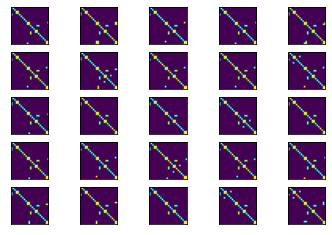

In [3]:
plt.figure(1)
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_3D[i, :, :])
plt.show()

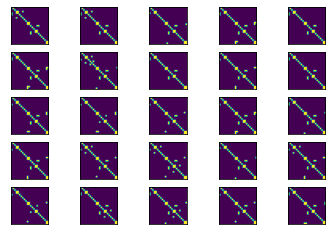

In [4]:
plt.figure(2)
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(val_3D[i, :, :])
plt.show()

In [3]:
print(str(time.ctime()) + ": Implementing PCA Clustering...")
train_pca = np.resize(train_3D, (train_3D.shape[0], int((train_3D.shape[1] * train_3D.shape[2]) / 2)))  # 616207 x 288
val_pca = np.resize(val_3D, (val_3D.shape[0], int((val_3D.shape[1] * val_3D.shape[2]) / 2)))  # 152052 x 288

sc = StandardScaler()
sc.fit(train_pca) # fit the scaler to the validation set
normalized_train_pca = sc.transform(train_pca)
normalized_val_pca = sc.transform(val_pca)  # normalize both sets

pca = PCA(n_components=2)  # define number of principle components needed
pca.fit(normalized_train_pca) # fit pca to validation set
normalized_train_pca = pca.transform(normalized_train_pca)
normalized_val_pca = pca.transform(normalized_val_pca) # reduce dimensions of both sets
# print(pca.explained_variance_ratio_)  # find how much of variance is explained by each component
print(str(time.ctime()) + ": Finished PCA Clustering!")

Mon Jun 14 10:38:46 2021: Implementing PCA Clustering...
Mon Jun 14 10:38:58 2021: Finished PCA Clustering!


Text(0.5, 1.0, 'Scatter plot showing PCA clustering for training dataset')

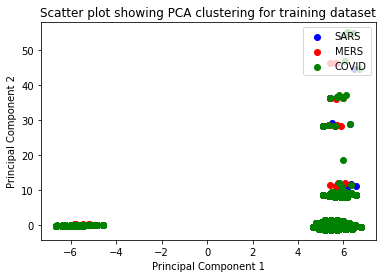

In [6]:
t_covid = normalized_train_pca[np.where(label_training == 0)]
t_mers = normalized_train_pca[np.where(label_training == 1)]
t_sars = normalized_train_pca[np.where(label_training == 2)]

plt.figure(1)
plt.scatter(t_covid[:, 0], t_covid[:, 1], c='b', label='SARS')
plt.scatter(t_mers[:, 0], t_mers[:, 1], c='r', label='MERS')
plt.scatter(t_sars[:, 0], t_sars[:, 1], c='g', label='COVID')
plt.legend(loc='upper right')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter plot showing PCA clustering for training dataset')

Text(0.5, 1.0, 'Scatter plot showing PCA clustering for validation dataset')

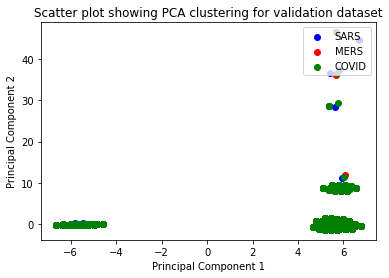

In [7]:
v_covid = normalized_val_pca[np.where(label_validation == 0)]
v_mers = normalized_val_pca[np.where(label_validation == 1)]
v_sars = normalized_val_pca[np.where(label_validation == 2)]

plt.figure(2)
plt.scatter(v_covid[:, 0], v_covid[:, 1], c='b', label='SARS', alpha=1)
plt.scatter(v_mers[:, 0], v_mers[:, 1], c='r', label='MERS', alpha=1)
plt.scatter(v_sars[:, 0], v_sars[:, 1], c='g', label='COVID', alpha=1)
plt.legend(loc='upper right')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter plot showing PCA clustering for validation dataset')

In [4]:
print(str(time.ctime()) + ": Implementing K-Means Clustering...")
km = KMeans(n_clusters=3, random_state=0)
labels_train = np.array(km.fit_predict(normalized_train_pca))
labels_val = np.array(km.fit_predict(normalized_val_pca))
print(str(time.ctime()) + ": Finished K-Means Clustering!")

Mon Jun 14 10:38:58 2021: Implementing K-Means Clustering...
Mon Jun 14 10:38:58 2021: Finished K-Means Clustering!


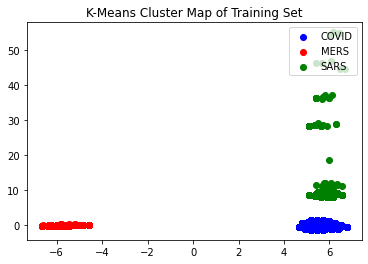

In [9]:
t_label0 = normalized_train_pca[np.where(labels_train == 0)]
t_label1 = normalized_train_pca[np.where(labels_train == 1)]
t_label2 = normalized_train_pca[np.where(labels_train == 2)]

plt.figure(3)
plt.scatter(t_label0[:, 0], t_label0[:, 1], c='b', label='COVID')
plt.scatter(t_label1[:, 0], t_label1[:, 1], c='r', label='MERS')
plt.scatter(t_label2[:, 0], t_label2[:, 1], c='g', label='SARS')
plt.title('K-Means Cluster Map of Training Set')
plt.legend(loc='upper right')

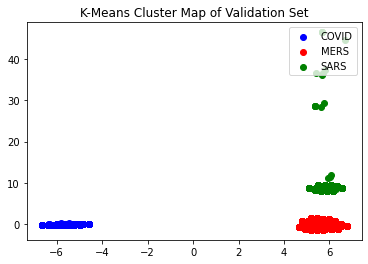

In [10]:
v_label0 = normalized_val_pca[np.where(labels_val == 0)]
v_label1 = normalized_val_pca[np.where(labels_val == 1)]
v_label2 = normalized_val_pca[np.where(labels_val == 2)]

plt.figure(4)
plt.scatter(v_label0[:, 0], v_label0[:, 1], c='b', label='COVID')
plt.scatter(v_label1[:, 0], v_label1[:, 1], c='r', label='MERS')
plt.scatter(v_label2[:, 0], v_label2[:, 1], c='g', label='SARS')
plt.title('K-Means Cluster Map of Validation Set')
plt.legend(loc='upper right')

In [88]:
print(str(time.ctime()) + ": Implementing ML Classification...")

train_Y_onehot = to_categorical(label_training) # model and ML for classification
test_Y_onehot = to_categorical(label_validation)

Mon Jun 14 12:17:01 2021: Implementing ML Classification...


In [89]:
train_X, valid_X, train_label, valid_label = train_test_split(trainset, train_Y_onehot, test_size=0.2, random_state=13)
# train_X = 492965 x 24 x 24 x 1
# valid_X = 123242 x 24 x 24 x 1
# train_label = 492965 x 3
# valid_label = 123242 x 3

In [90]:
print(str(time.ctime()) + ": Creating Classification Model...")

x = Input(shape=(24, 24, 1))  # 24 x 24 x 1
e_conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # 24 x 24 x 32
pool1 = MaxPool2D((2, 2), padding='same')(e_conv1)  # 12 x 12 x 32
b_norm1 = BatchNormalization()(pool1)

e_conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(b_norm1)  # 12 x 12 x 64
pool2 = MaxPool2D((2, 2), padding='same')(e_conv2)  # 6 x 6 x 64
b_norm2 = BatchNormalization()(pool2)

e_conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(b_norm2)  # 6 x 6 x 128

f1 = Flatten()(e_conv3) # add a fully connected layer after just the encoding 
dense_1 = Dense(128, activation='relu')(f1)
r = Dense(3, activation='softmax')(dense_1)

classification_model = Model(x, r) # compile full model
classification_model.compile(loss='mse', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])

print(str(time.ctime()) + ": Successfully created Classification Model")

Mon Jun 14 12:19:58 2021: Creating Classification Model...
Mon Jun 14 12:19:58 2021: Successfully created Classification Model


In [74]:
print(str(time.ctime()) + ": Training Classification Model...")

epochs = 10
batch_size = 128
classify_labels = classification_model.fit(train_X, train_label, batch_size=batch_size, epochs=epochs, validation_data=(valid_X, valid_label))

print(str(time.ctime()) + ": Finished training!")

Epoch 1/10
3852/3852 [==============================] - 11s 3ms/step - loss: 0.1116 - accuracy: 0.7249 - val_loss: 0.1006 - val_accuracy: 0.7413
Epoch 2/10
3852/3852 [==============================] - 10s 3ms/step - loss: 0.1004 - accuracy: 0.7414 - val_loss: 0.1006 - val_accuracy: 0.7401
Epoch 3/10
3852/3852 [==============================] - 11s 3ms/step - loss: 0.1002 - accuracy: 0.7424 - val_loss: 0.1004 - val_accuracy: 0.7414
Epoch 4/10
3852/3852 [==============================] - 11s 3ms/step - loss: 0.1001 - accuracy: 0.7423 - val_loss: 0.1003 - val_accuracy: 0.7413
Epoch 5/10
3852/3852 [==============================] - 11s 3ms/step - loss: 0.1001 - accuracy: 0.7432 - val_loss: 0.1004 - val_accuracy: 0.7410
Epoch 6/10
3852/3852 [==============================] - 11s 3ms/step - loss: 0.1001 - accuracy: 0.7419 - val_loss: 0.1002 - val_accuracy: 0.7415
Epoch 7/10
3852/3852 [==============================] - 11s 3ms/step - loss: 0.1000 - accuracy: 0.7421 - val_loss: 0.1005 - val_ac

In [78]:
print(str(time.ctime()) + ": Evaluating Classification Model...")

test_eval = classification_model.evaluate(valset, test_Y_onehot)
print('Loss: ' + str(test_eval[0]))
print('Accuracy: ' + str(test_eval[1]))

print(str(time.ctime()) + ": Finished evaluation!")

4815/4815 [==============================] - 6s 1ms/step - loss: 0.1005 - accuracy: 0.7413
Loss: 0.10054603219032288
Accuracy: 0.7413016557693481


In [79]:
print(str(time.ctime()) + ": Predicting with Classification Model...")

predicted = classification_model.predict(valset)
predicted = np.argmax(np.round(predicted), axis=1)

print(str(time.ctime()) + ": Finished predictions!")

In [100]:
correct = np.where(predicted == label_validation)[0]
incorrect = np.where(predicted != label_validation)[0]
print("Number of Correct Classifications: " + str(len(correct)))
print("Number of Incorrect Classifications: " + str(len(incorrect)))

Number of Correct Classifications: 114199
Number of Incorrect Classifications: 39853


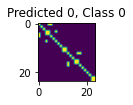

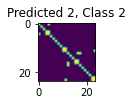

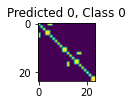

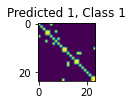

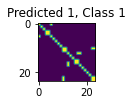

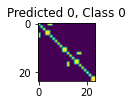

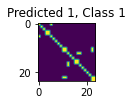

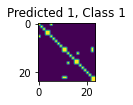

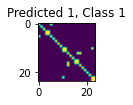

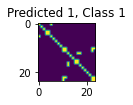

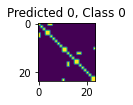

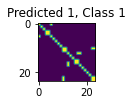

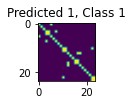

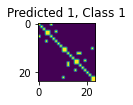

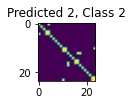

In [101]:
plt.figure(7)
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(valset[correct[i], :, :])
    plt.title("Predicted {}, Class {}".format(predicted[correct[i]], int(label_validation[correct[i]])))
    plt.show()